For any modijfications of the library 

cd \Desktop\AMR WS\Final Project\src

pip3 install -e do-mpc

In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
from casadi import *
import do_mpc

In [3]:
model_type = 'continuous'
model = do_mpc.model.Model(model_type)

In [4]:
#the model is configured with the following parameters:
m0 = 0.6 # kg, mass of the cart
m1 = 0.2 # kg, mass of the first rod
m2 = 0.2 # kg, mass of the second rod
#L1 = 0.5 # m, length of the first rod
L2 = 0.5 # m, length of the second rod

g = 9.80665 # m/s^2, gravitational acceleration

# Uncertain parameters:
L1  = model.set_variable('_p',  'L1')


In [5]:
# We furthermore introduce the following derived parameters to conveniently formulate the model equations below.

l1 = L1/2 # m,
l2 = L2/2 # m,
J1 = (m1 * l1**2) / 3   # Inertia
J2 = (m2 * l2**2) / 3   # Inertia

h1 = m0 + m1 + m2
h2 = m1*l1 + m2*L1
h3 = m2*l2
h4 = m1*l1**2 + m2*L1**2 + J1
h5 = m2*l2*L1
h6 = m2*l2**2 + J2
h7 = (m1*l1 + m2*L1) * g
h8 = m2*l2*g

In [6]:
# x = [x, theta1, theta2, dx, dtheta1, dtheta2]
# u = f

pos = model.set_variable('_x', 'pos')
theta = model.set_variable('_x', 'theta', (2,1))
dpos = model.set_variable('_x', 'dpos')
dtheta = model.set_variable('_x', 'dtheta', (2,1))

u = model.set_variable('_u', 'force')



In [7]:
# DIFFERENTIAL ALGEBRAIC EQUATION approach
ddpos = model.set_variable('_z', 'ddpos')
ddtheta = model.set_variable('_z', 'ddtheta', (2,1))

In [8]:
model.set_rhs('pos', dpos)
model.set_rhs('theta', dtheta)
model.set_rhs('dpos', ddpos)
model.set_rhs('dtheta', ddtheta)

In [9]:
euler_lagrange = vertcat(
        # 1
        h1*ddpos+h2*ddtheta[0]*cos(theta[0])+h3*ddtheta[1]*cos(theta[1])
        - (h2*dtheta[0]**2*sin(theta[0]) + h3*dtheta[1]**2*sin(theta[1]) + u),
        # 2
        h2*cos(theta[0])*ddpos + h4*ddtheta[0] + h5*cos(theta[0]-theta[1])*ddtheta[1]
        - (h7*sin(theta[0]) - h5*dtheta[1]**2*sin(theta[0]-theta[1])),
        # 3
        h3*cos(theta[1])*ddpos + h5*cos(theta[0]-theta[1])*ddtheta[0] + h6*ddtheta[1]
        - (h5*dtheta[0]**2*sin(theta[0]-theta[1]) + h8*sin(theta[1]))
    )

model.set_alg('euler_lagrange', euler_lagrange)
# Solves for ddpos and ddtheta and then finds the state variables

In [10]:
# Introduction of energy equations for the formulation of the MPC controller

E_kin_cart = 1 / 2 * m0 * dpos**2
E_kin_p1 = 1 / 2 * m1 * (
    (dpos + l1 * dtheta[0] * cos(theta[0]))**2 +
    (l1 * dtheta[0] * sin(theta[0]))**2) + 1 / 2 * J1 * dtheta[0]**2
E_kin_p2 = 1 / 2 * m2 * (
    (dpos + L1 * dtheta[0] * cos(theta[0]) + l2 * dtheta[1] * cos(theta[1]))**2 +
    (L1 * dtheta[0] * sin(theta[0]) + l2 * dtheta[1] * sin(theta[1]))**
    2) + 1 / 2 * J2 * dtheta[0]**2

E_kin = E_kin_cart + E_kin_p1 + E_kin_p2

E_pot = m1 * g * l1 * cos(
theta[0]) + m2 * g * (L1 * cos(theta[0]) +
                            l2 * cos(theta[1]))

model.set_expression('E_kin', E_kin)
model.set_expression('E_pot', E_pot)

SX(@1=1.96133, (((@1*(L1/2))*cos(theta_0))+(@1*((L1*cos(theta_0))+(0.25*cos(theta_1))))))

In [11]:
# Build the model
model.setup()

In [12]:
mpc = do_mpc.controller.MPC(model)

In [13]:
setup_mpc = {
    'n_horizon': 80, # prediction horizion
    'n_robust': 1, # robust horizon
    'open_loop': 0, # if set to false, for each time step and scenario an individual control input it computed
    't_step': 0.04,  # timestep of the mpc
    'state_discretization': 'collocation', # state siscretization for continuous model (only collocation is available)
    'collocation_type': 'radau', # collocation type, only 'radau' is available
    'collocation_deg': 3, # collocation degree, defaults to 2
    'collocation_ni': 1, # number of finite elements for the states within a time-step (defauls to 1)
    'store_full_solution': True, # choose whether to store the full solution of the optimization problem
    # Use MA27 linear solver in ipopt for faster calculations:
    'nlpsol_opts': {'ipopt.linear_solver': 'mumps'}
}
mpc.set_param(**setup_mpc)

In [14]:
# Energy based formulation for the objective.
# We want to maximize the potential energy (up-up position)
# and minimize the kinetic energy (stabilization)

mterm = model.aux['E_kin'] - model.aux['E_pot'] # terminal cost
lterm = model.aux['E_kin'] - model.aux['E_pot'] # stage cost

mpc.set_objective(mterm = mterm, lterm = lterm)
# Input force is implicitly restricted through the objective
mpc.set_rterm(force = 0.1)


In [15]:
# set the constraints of the control problem
mpc.bounds['lower','_u','force'] = -4
mpc.bounds['upper','_u','force'] = 4

In [16]:
L1_values = np.array([0.4, 0.5, 0.6])

mpc.set_uncertainty_values(L1 = L1_values)

In [17]:
mpc.setup()

-- Probability distribution modes -- 
1. Manual distrinution 
2. Hierarchical distribution 
Select prefered mode: 1
There are [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3] scenarios, insert the aproximate probability value for each one by one.


UnboundLocalError: local variable 'scenario_indexes' referenced before assignment

In [26]:
from scipy.stats import expon

n_scenarios = 10 

dist = [expon.cdf(x,loc=0, scale=5) for x in range(1,n_scenarios+1)]

print(dist)
print(sum(dist))

dist = (dist/sum(dist))[::-1]
print(dist)
print(sum(dist))


[0.18126924692201815, 0.3296799539643607, 0.4511883639059735, 0.5506710358827784, 0.6321205588285577, 0.6988057880877978, 0.7534030360583935, 0.7981034820053446, 0.8347011117784134, 0.8646647167633873]
6.094607294197025
[0.14187374 0.13695732 0.1309524  0.12361798 0.11465969 0.10371801
 0.09035382 0.07403075 0.05409372 0.02974256]
1.0


In [18]:
# We assume that all states can be directly measured
estimator = do_mpc.estimator.StateFeedback(model)

In [19]:
# Create simulator in order to run MPC in a closed-loop
simulator = do_mpc.simulator.Simulator(model)

In [20]:
params_simulator = {
    # Note: cvode doesn't support DAE systems
    'integration_tool': 'idas',
    'abstol': 1e-10,
    'reltol': 1e-10,
    't_step': 0.04 # same time-step as the optimizer
}

simulator.set_param(**params_simulator)


In [21]:
p_num = simulator.get_p_template()
#p_num['L1'] = 0.5
p_num['L1'] = np.random.normal(0.5,0.1)


# function definition
def p_fun(t_now):
    return p_num

# Set the user-defined function above as the function for the realization of the uncertain parameters
simulator.set_p_fun(p_fun)


In [22]:
simulator.setup()

In [23]:
# Define the initial state of the system and set for all parts of the closed-loop configuration:
simulator.x0['theta'] = 0.99*np.pi # exactly pi would give numerical issues

x0 = simulator.x0.cat.full()

mpc.x0 = x0
estimator.x0 = x0

mpc.set_initial_guess()

In [24]:
# auxiliary variables that code the structure of the tree
# _setup_scenario_tree() is a private method used inside the mpc class
# here it is used only to inspect the values of those variables
# not needed to call "make_step" at runtime

n_branches, n_scenarios, child_scenario, parent_scenario, branch_offset = mpc._setup_scenario_tree()
n_max_scenarios = mpc.n_combinations ** mpc.n_robust

In [25]:
# this is how the weighting factors of the tree are computed
# there is one value per step, same weight for each scenario
# directly taken from source code for inspection

omega = [1. / n_scenarios[k + 1] for k in range(mpc.n_horizon)]
omega

[0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333333333,
 0.3333333333

In [26]:
import matplotlib.pyplot as plt
plt.ion() # interactive mode on
from matplotlib import rcParams
rcParams['text.usetex'] = False
rcParams['axes.grid'] = True
rcParams['lines.linewidth'] = 2.0
rcParams['axes.labelsize'] = 'xx-large'
rcParams['xtick.labelsize'] = 'xx-large'
rcParams['ytick.labelsize'] = 'xx-large'

In [27]:
mpc_graphics = do_mpc.graphics.Graphics(mpc.data)
sim_graphics = do_mpc.graphics.Graphics(simulator.data)


In [28]:
%%capture
fig, ax = plt.subplots(4, sharex=True, figsize=(16,9), constrained_layout=True)

for g in [sim_graphics,mpc_graphics]:
    # Plot the state on axis 1 to 4:
    g.add_line(var_type='_aux', var_name='E_kin', axis=ax[0])
    g.add_line(var_type='_aux', var_name='E_pot', axis=ax[1])
    g.add_line(var_type='_x', var_name='theta', axis=ax[2])
    g.add_line(var_type='_u', var_name='force', axis=ax[3])
#    g.add_line(var_type='_x', var_name='pos', axis=ax[4])


ax[0].set_ylabel(r'$E_{kin}$ [J]')
ax[1].set_ylabel(r'$E_{pot}$ [J]')
ax[2].set_ylabel(r'Angle  [rad]')
ax[3].set_ylabel(r'Input force [N]')
#ax[4].set_ylabel(r'Position [m]')
ax[-1].set_xlabel(r'time [s]')

fig.align_ylabels()
fig.tight_layout()


In [29]:
%%capture
u0 = mpc.make_step(x0)

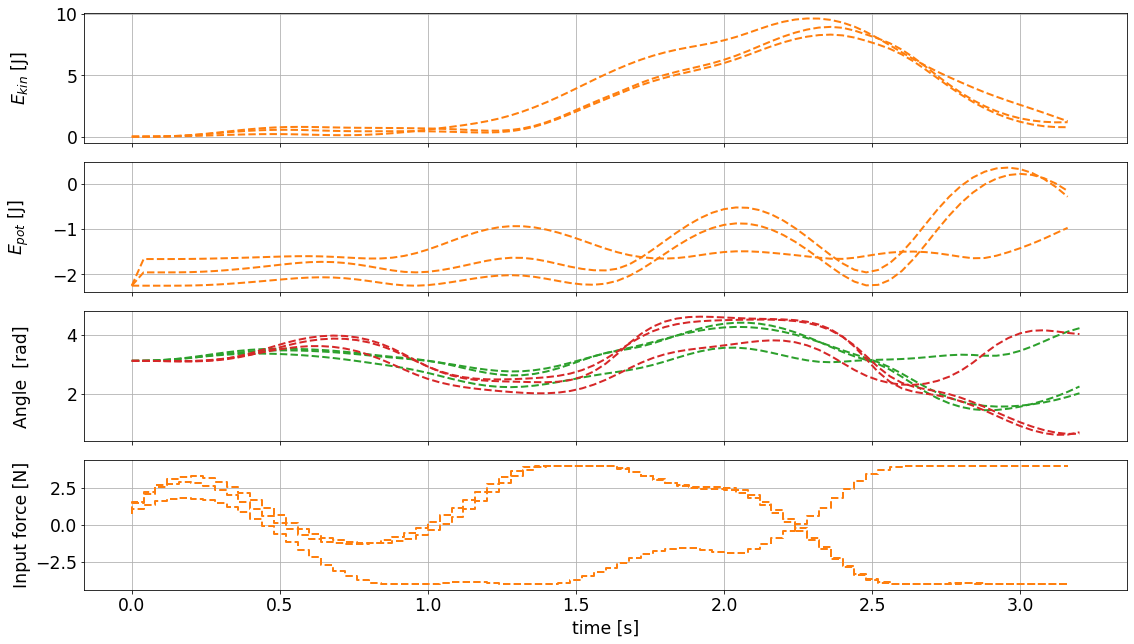

In [30]:
mpc_graphics.plot_predictions()
mpc_graphics.reset_axes()

fig

In [31]:
%%capture
# Quickly reset the history of the MPC data object.
mpc.reset_history()

n_steps = 50
for k in range(n_steps):
    u0 = mpc.make_step(x0)
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)

In [32]:
from matplotlib.animation import FuncAnimation, FFMpegWriter, ImageMagickWriter

# The function describing the gif:
#x_arr = mpc.data['_x']
def update(t_ind):
    sim_graphics.plot_results(t_ind)
    #mpc_graphics.plot_results(t_ind)
    mpc_graphics.plot_predictions(t_ind)
    mpc_graphics.reset_axes()


anim = FuncAnimation(fig, update, frames=n_steps, repeat=False)
gif_writer = ImageMagickWriter(fps=20)
anim.save('anim_dip_mod.gif', writer=gif_writer)

ExecutableNotFoundError: Failed to find an ImageMagick installation

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display

In [ ]:
from pathlib import Path
gifPath = Path("./anim_dip_mod.gif")
# Display GIF in Jupyter, CoLab, IPython
with open(gifPath,'rb') as f:
    display.Image(data=f.read(), format='png')